In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#%load_ext memory_profiler
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
import scipy.ndimage
#POPPY
import poppy
from poppy.poppy_core import PlaneType
print("POPPY Version: "+poppy.__version__)
#silence DEBUG and WARNINGs
import logging
logging.getLogger('poppy').setLevel(logging.ERROR)
# MagAO-X function definitions
from model_kit import magaoxFunctions as mf
from model_kit import datafiles as dfx
# draw the dark hole regions
from skimage.draw import draw
# for writing files
from datetime import date
print('Last date this notebook was ran: {0}'.format(date.today()))
import copy

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#print('This notebook is not stale yet!')

def rms(data):
    return np.sqrt(np.sum(np.square(data))/len(data))

POPPY Version: 0.9.2.dev11+g1887dd5
Last date this notebook was ran: 2021-11-09


In [2]:
# initial conditions
fr_parm = {'wavelength': 656e-9 * u.m,
           'npix': 538, # sample size
           'beam_ratio': 0.25, # oversample
           'leak_mult': 0.01,
           'n_tests': 10,
           'n_loop': 4,
           'set': 0,
           'bump': True,
           'wfe_data': 'allopd'} # other: 'allopd', 'common'

# set up prescription details
wavelen_str = str(np.round(fr_parm['wavelength'].to(u.nm).value).astype(int))
br = int(1/fr_parm['beam_ratio'])
parm_name = '{0:3}_{1:1}x_{2}nm'.format(fr_parm['npix'], br, wavelen_str)

# set up file locations
home_dir = '/home/jhen/XWCL/code/MagAOX/' # laptop local
data_dir = home_dir + 'data/'

# open all the masks
tw_mask = fits.open(data_dir+'mask/lyot_tweeter_amp_mask_bump_538.fits')[0].data

### Initializing and Saving the data
Don't run these cells unless the data is present. Instead, can skip a few cells down to the figure generating.

In [3]:
%%time
# Build the diffraction limited PSF without vAPP for Strehl calculation

# load the CSV prescription values
rx_loc_difflim = data_dir+'rxCSV/rx_magaox_NCPDM_sci_{0}_noap_{1}.csv'.format(parm_name, 
                                                                              'nowfe')
rx_difflim = mf.makeRxCSV(rx_loc_difflim)

# remove the vAPP
tweeter_num = 16
vappTRANS_num = 23
vappOPD_num = vappTRANS_num+1
rx_difflim['surf_PSD_filename'][vappTRANS_num] = 'none'
rx_difflim['surf_PSD_filename'][vappOPD_num] = 'none'

# calculate in POPPY
magaox = mf.csvFresnel(rx_csv=rx_difflim, 
                       samp=fr_parm['npix'], 
                       oversamp=fr_parm['beam_ratio'],
                       home_folder=home_dir, 
                       break_plane='F69Sci',
                       bump=fr_parm['bump'])
dl_psf = magaox.calc_psf(wavelength=fr_parm['wavelength'].value)[0]
dl_max = np.amax(dl_psf.data)

CPU times: user 1min 1s, sys: 11.7 s, total: 1min 13s
Wall time: 29.9 s


In [12]:
# all opd optics
fr_parm['n_loop'] = 10

ph = np.zeros((fr_parm['n_loop'], fr_parm['n_tests']))
dm_rms = np.zeros((fr_parm['n_loop'], fr_parm['n_tests']))

fr_parm['wfe_data'] = 'allopd'
fr_folder = 'n0_{0}_{1}_cal_dmloop/'.format(fr_parm['wfe_data'], fr_parm['npix'])

for j_set in range(0, fr_parm['n_tests']):
    # chooses which random set, which is the row value
    
    # before beginning calculation, initialize the 0th state.
    init_dm_data = fits.open(data_dir+'wfemap/tweeter_meters_opd_538.fits')[0].data
    prev_dm = rms(init_dm_data[tw_mask==1])*1e9

    init_ph_data = fits.open(fr_folder+'wf_s{0}_i0_phase.fits'.format(j_set))[0].data
    prev_ph = rms(init_ph_data[tw_mask==1])
    
    for j_loop in range(1, fr_parm['n_loop']+1):
        # loop iteration
        
        # wfs phase - closed loop
        ph_fileloc = 'wf_s{0}_i{1}_phase.fits'.format(j_set, j_loop)
        ph_data = fits.open(fr_folder+ph_fileloc)[0].data
        current_ph = rms(ph_data[tw_mask==1])
        ph[j_set][j_loop-1] = current_ph - prev_ph
        
        # DM rms - closed loop
        dm_fileloc = 'dm_opd_s{0}_i{1}.fits'.format(j_set, j_loop)
        dm_data = fits.open(fr_folder+dm_fileloc)[0].data
        current_dm = rms(dm_data[tw_mask==1])*1e9
        dm_rms[j_set][j_loop-1] = current_dm - prev_dm
        
        # reset for next loop
        prev_dm = current_dm
        prev_ph = current_ph
        
# calculate the average
avg_dm = np.mean(dm_rms, axis=0)
avg_ph = np.mean(ph, axis=0)

In [17]:
# Save the data
# writer header
hdr = fits.Header()
hdr['comment'] = 'allopd, thin spiders, closed loop data'
hdr['comment'] = 'WFSC iterations changes'
hdr['comment'] = 'row: PSD set (10 total)'
hdr['comment'] = 'col: loop iteration change (10 total)'
hdr['comment'] = 'data is change from previous state'

# write fits file
fits.writeto('data_reduce/fresnelmetric_{0}_dmloop_dmrms.fits'.format(fr_parm['wfe_data']),
             dm_rms, hdr, overwrite=True)
fits.writeto('data_reduce/fresnelmetric_{0}_dmloop_wfsph.fits'.format(fr_parm['wfe_data']),
             ph, hdr, overwrite=True)

### Figure generating
Only works if the post-processed FITS file with the data is in the directory.

In [5]:
# open the data
ph = fits.open('data_reduce/fresnelmetric_{0}_dmloop_wfsph.fits'.format(fr_parm['wfe_data']))[0].data
dm_rms = fits.open('data_reduce/fresnelmetric_{0}_dmloop_dmrms.fits'.format(fr_parm['wfe_data']))[0].data

avg_dm = np.mean(dm_rms, axis=0)
avg_ph = np.mean(ph, axis=0)

fr_parm['n_loop'] = 10

In [11]:
i=4
(avg_ph[i]/avg_ph[0], avg_dm[i]/avg_dm[0])

(0.0009707524820771079, 0.0010868106141963562)

([<matplotlib.axis.XTick at 0x7fddc0fc47d0>,
 <a list of 10 Text xticklabel objects>)

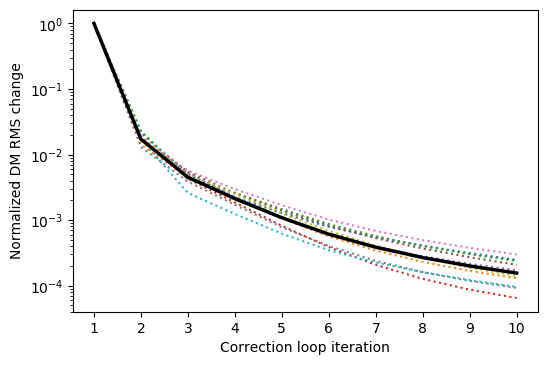

In [6]:
xit = np.arange(1,fr_parm['n_loop']+1)
plt.figure(dpi=100, facecolor='white')
for jp in range(0, fr_parm['n_tests']):
    plt.plot(xit, dm_rms[jp][0:]/dm_rms[jp][0], ':', label='psd{0}'.format(jp))
plt.plot(xit, avg_dm[0:]/avg_dm[0], 'k', linewidth=2.5, label='average')
plt.xlabel('Correction loop iteration')
plt.ylabel('Normalized DM RMS change')
plt.yscale('log')
plt.xticks(ticks=xit)

([<matplotlib.axis.XTick at 0x7fdd93dc6350>,
 <a list of 10 Text xticklabel objects>)

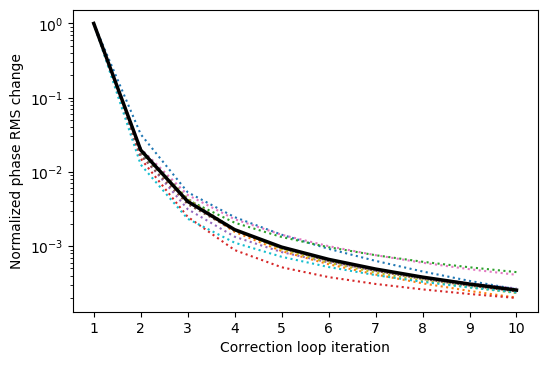

In [7]:
xit = np.arange(1,fr_parm['n_loop']+1)
plt.figure(dpi=100, facecolor='white')
for jp in range(0, fr_parm['n_tests']):
    plt.plot(xit, ph[jp][0:]/ph[jp][0], ':', label='psd{0}'.format(jp))
plt.plot(xit, avg_ph[0:]/avg_ph[0], 'k', linewidth=2.5, label='average')
plt.xlabel('Correction loop iteration')
plt.ylabel('Normalized phase RMS change')
plt.yscale('log')
plt.xticks(ticks=xit)